# Annotating Datasets with CVAT

[FiftyOne](https://fiftyone.ai) and [CVAT](https://github.com/opencv/cvat) are two leading open-source tools, each tackling different parts of the dataset curation and improvement workflows.

[The tight integration](https://voxel51.com/docs/fiftyone/integrations/cvat.html) between FiftyOne and CVAT allows you to curate and explore datasets in FiftyOne and then send off samples or existing labels for annotation in CVAT with just one line of code.

This walkthrough covers:

* Selecting subsets and annotating unlabeled image datasets with CVAT
* Improving datasets and fixing annotation mistakes with CVAT
* Annotating videos with CVAT

**So, what's the takeaway?**

FiftyOne makes it incredibly easy to explore datasets, understand them, and discover ways to improve them. This walkthrough covers the imporant next step: using CVAT to **take action** to both annotate datasets and correct existing label deficiencies that you've identified in your datasets.

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

In order to use CVAT, you must create an account on a CVAT server.

By default, FiftyOne uses [app.cvat.ai](https://app.cvat.ai). So if you haven't already, go to [app.cvat.ai](https://app.cvat.ai) and create an account now.

Another option is to [set up CVAT locally](https://opencv.github.io/cvat/docs/administration/basics/installation) and then [configure FiftyOne](https://voxel51.com/docs/fiftyone/integrations/cvat.html#self-hosted-servers) to use your self-hosted server. A primary benefit of setting up CVAT locally is that you are limited to 10 tasks and 500MB of data with app.cvat.ai.

In any case, FiftyOne will need to connect to your CVAT account. The easiest way to configure your CVAT login credentials is to store them in environment variables:

In [ ]:
!export FIFTYONE_CVAT_USERNAME=<YOUR_USERNAME>
!export FIFTYONE_CVAT_PASSWORD=<YOUR_PASSWORD>
!export FIFTYONE_CVAT_EMAIL=<YOUR_EMAIL>  # if applicable

There are also [other ways](https://voxel51.com/docs/fiftyone/integrations/cvat.html#setup) to configure your login credentials if you prefer.

In this tutorial we’ll use the UMAP technique for visualizing samples in a 2D scatterplot. We'll also **optionally** run an object detection model that requires TensorFlow:

In [ ]:
!pip install umap-learn tensorflow 

## Unlabeled dataset annotation

For most machine learning projects, the first step is to collect a suitable dataset for the task. For computer vision projects specifically, this will generally result in thousands of images or videos that have been gathered from internet sources like [Flickr](https://www.flickr.com/) or captured by new footage from a data acquisition team.

With collections containing thousands or millions of samples, the cost to annotate every single sample can be astronomical. It thus makes sense to ensure that only the most useful and relevant data is being sent to annotation. One metric for how "useful" data is in training a model is how unique the example is with respect to the rest of the dataset. Multiple similar examples will not provide the model with as much new information to learn as visually unique examples.

FiftyOne provides a [visual similarity capability](https://voxel51.com/docs/fiftyone/user_guide/brain.html#visual-similarity) that we'll use in this tutorial to select some unique images to annotate.

### Loading data

We begin by [loading a set of unlabeled images into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html). This can be done in just one line of code. For example, if you are [using your own data](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html) you can run the following:

In [1]:
# Example
import fiftyone as fo

dataset_dir = "/path/to/raw/data"
name = "my_dataset"

dataset = fo.Dataset.from_dir(
    dataset_dir=dataset_dir,
    dataset_type=fo.types.ImageDirectory,
    name=name,
)

 100% |█████████████████████| 0/0 [3.5ms elapsed, ? remaining, ? samples/s] 


However, in this walkthrough, we'll download some images from the [Open Images V6 dataset](https://voxel51.com/docs/fiftyone/integrations/open_images.html) using the built-in [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html).

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    label_types=[],
    max_samples=200,
)

Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading 'open-images-v6' split 'validation'
 100% |█████████████████| 200/200 [72.4ms elapsed, 0s remaining, 2.8K samples/s]   
Dataset 'open-images-v6-validation-200' created


Now let's make the dataset [persistent](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#dataset-persistence) so that we can access it in future Python sessions.

In [ ]:
dataset.persistent = True

Now that the data is loaded, let's visualize it in the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html):


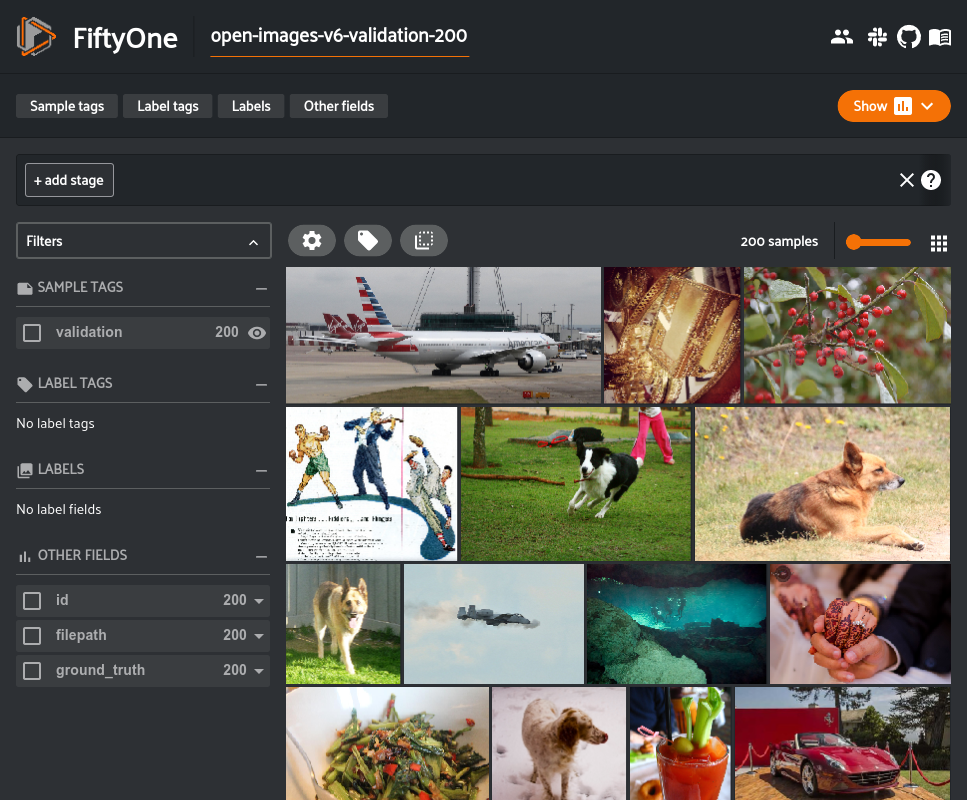

In [3]:
session = fo.launch_app(dataset)

In [4]:
session.freeze() # screen shot the App for this example

### Finding unique samples

Now let's run the [compute_similarity()](https://voxel51.com/docs/fiftyone/user_guide/brain.html#visual-similarity) method on the dataset in order to index all samples in the dataset by their visual similarity.

Once this is done, we can then use the index to find the most unique samples:

In [5]:
import fiftyone.brain as fob

results = fob.compute_similarity(dataset, brain_key="img_sim")
results.find_unique(100)

Computing embeddings...
 100% |█████████████████| 200/200 [2.2m elapsed, 0s remaining, 1.7 samples/s]      
Generating index...
Index complete
Computing unique samples...
threshold: 1.000000, kept: 200, target: 100
threshold: 2.000000, kept: 200, target: 100
threshold: 4.000000, kept: 200, target: 100
threshold: 8.000000, kept: 122, target: 100
threshold: 16.000000, kept: 7, target: 100
threshold: 12.000000, kept: 26, target: 100
threshold: 10.000000, kept: 66, target: 100
threshold: 9.000000, kept: 81, target: 100
threshold: 8.500000, kept: 98, target: 100
threshold: 8.250000, kept: 107, target: 100
threshold: 8.375000, kept: 103, target: 100
threshold: 8.437500, kept: 102, target: 100
threshold: 8.468750, kept: 100, target: 100
Uniqueness computation complete


We can also visualize the exact samples that were selected.

Computing embeddings...
 100% |█████████████████| 200/200 [2.1m elapsed, 0s remaining, 1.7 samples/s]      
Generating visualization...
UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Fri Aug 20 13:59:55 2021 Finding Nearest Neighbors
Fri Aug 20 13:59:58 2021 Finished Nearest Neighbor Search
Fri Aug 20 14:00:01 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Aug 20 14:00:05 2021 Finished embedding


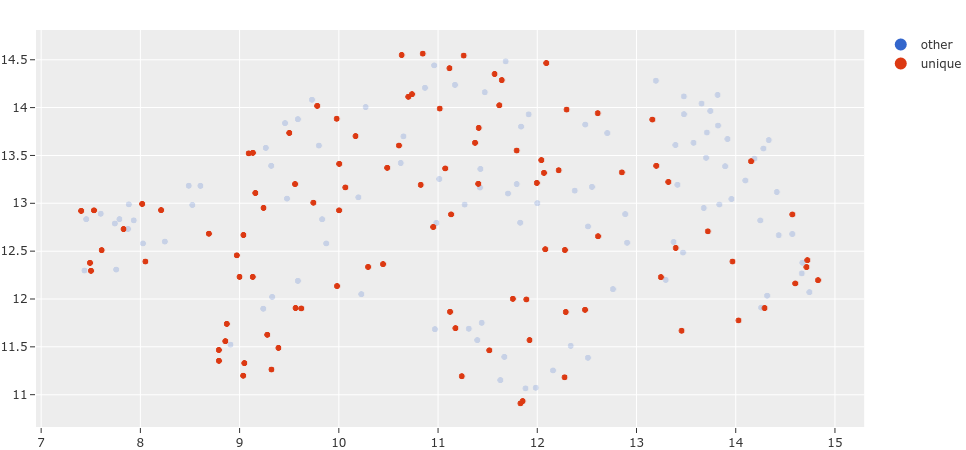

In [6]:
vis_results = fob.compute_visualization(dataset, brain_key="img_vis")

plot = results.visualize_unique(visualization=vis_results)
plot.show()

This plot [can be interacted with](https://voxel51.com/docs/fiftyone/user_guide/plots.html) by attaching it to your `session` object, allowing you to select points in the plot and visualize them in the App.

*Note: Interactive plots currently only work in Jupyter notebook environments.*


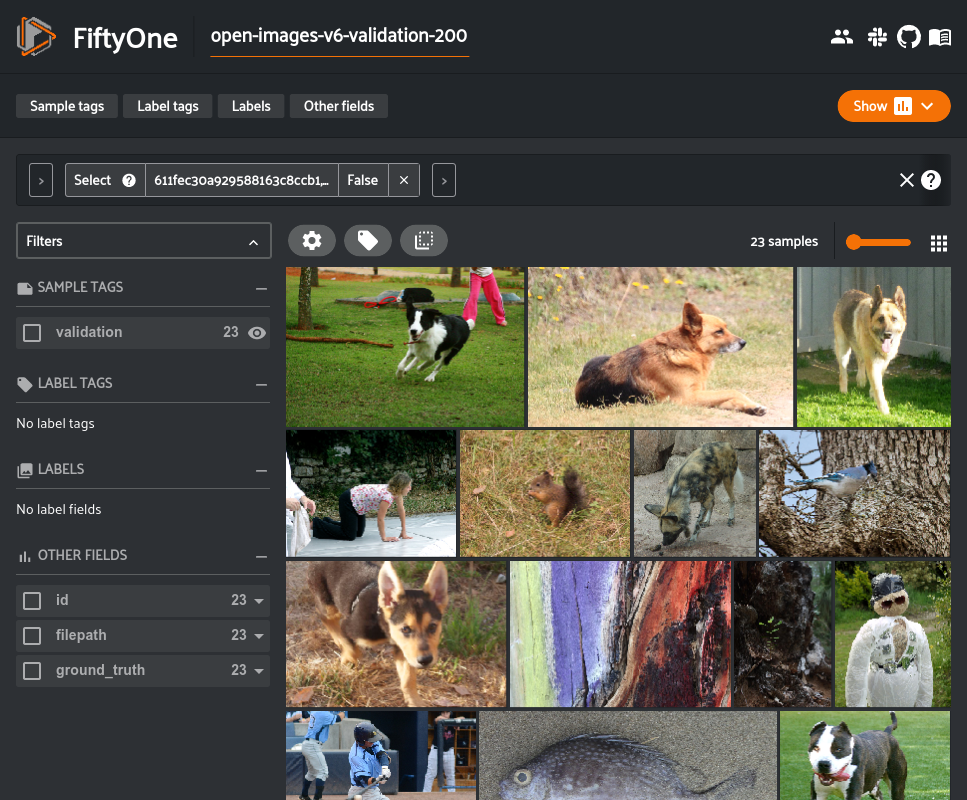

In [8]:
session.plots.attach(plot, name="unique")
session.show()

Now let's create a [DatasetView](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) into the dataset containing only the unique samples that were selected and visualize them.


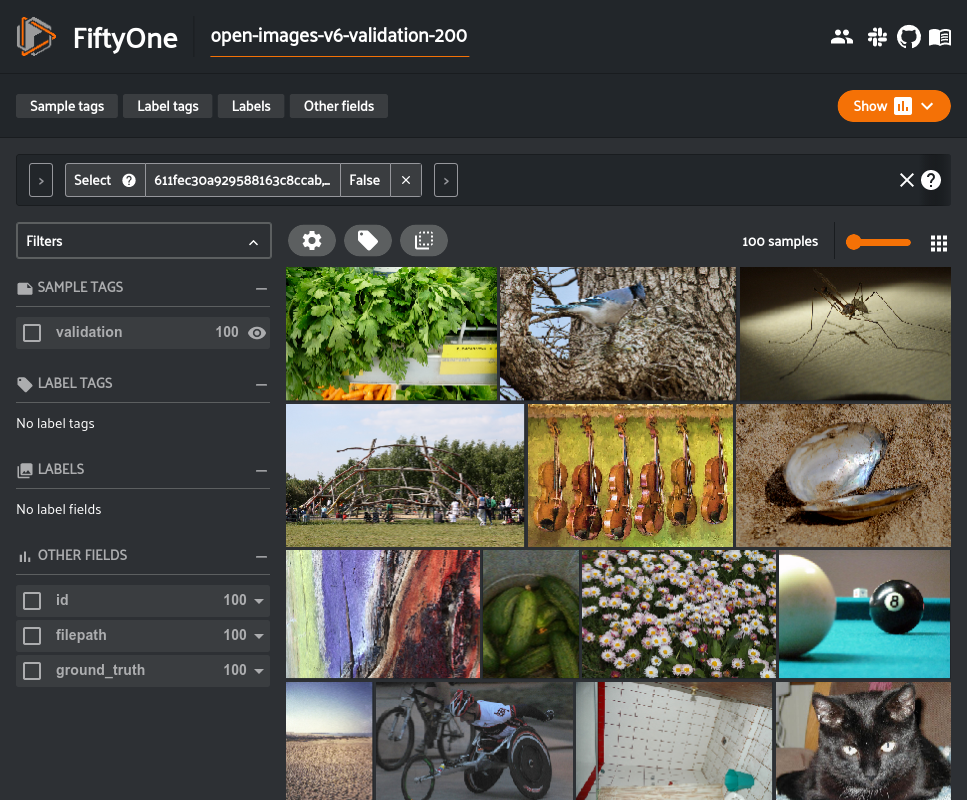

In [9]:
unique_view = dataset.select(results.unique_ids)
session.view = unique_view

In [10]:
session.freeze()

Having reduced the number of samples that need to be annotated, the time and cost of annotating this dataset have also been reduced.

### Annotating samples in CVAT

Whether you are annotating the data yourself or have a team of annotators, the workflow of uploading data from FiftyOne to CVAT is the same. The [annotate()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.annotate) method on a collection of samples lets you specify the name, type, and classes for the labels you are annotating.

For example, let's annotate instance segmentation masks for the classes "person", "vehicle", and "animal".

We'll only include a few samples to be annotated in our view for brevity. To create annotation jobs in CVAT for these samples, we simply call [annotate()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.annotate) passing in a unique name for this annotation run and the relevant label schema information for the annotation task.
Since we'll be annotating these samples ourselves, we pass `launch_editor=True` to automatically launch a browser window with the CVAT editor open once the data has been loaded.

In [10]:
# Randomly select 5 samples to load to CVAT
unique_5_view = unique_view.take(5)

# A unique identifer for this run
anno_key = "segs_run"

# Upload the samples and launch CVAT
anno_results = unique_5_view.annotate(
    anno_key,
    label_field="segmentations",
    label_type="instances",
    classes=["person", "vehicle", "animal"],
    launch_editor=True,
)

Uploading samples to CVAT...
Computing image metadata...
 100% |█████████████████████| 5/5 [151.6ms elapsed, 0s remaining, 33.0 samples/s] 
Upload complete
Launching editor at 'https://app.cvat.ai/tasks/386/jobs/441'...


The `CVATAnnotationResults` object that was returned can be used to get the current status of the tasks that were created:

In [12]:
anno_results.print_status()


Status for label field 'segmentations':

	Task 386 (FiftyOne_open-images-v6-validation-200_segmentations):
		Status: annotation
		Assignee: None
		Last updated: 2021-08-20T21:22:37.928988Z
		URL: https://app.cvat.ai/tasks/386

		Job 441:
			Status: annotation
			Assignee: None
			Reviewer: None



![cvat-seg](images/cvat_segmentation.png)

Once the annotation is complete and saved in CVAT, we can download the annotations and automatically update our dataset by calling [load_annotations()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.load_annotations).

Since accounts on app.cvat.ai only allow for 10 tasks, we'll set `cleanup=True` so that the CVAT tasks are automatically deleted after the annotations are loaded.

Download complete
Adding labels for 'segmentations'...
 100% |█████████████████████| 5/5 [76.5ms elapsed, 0s remaining, 65.4 samples/s] 



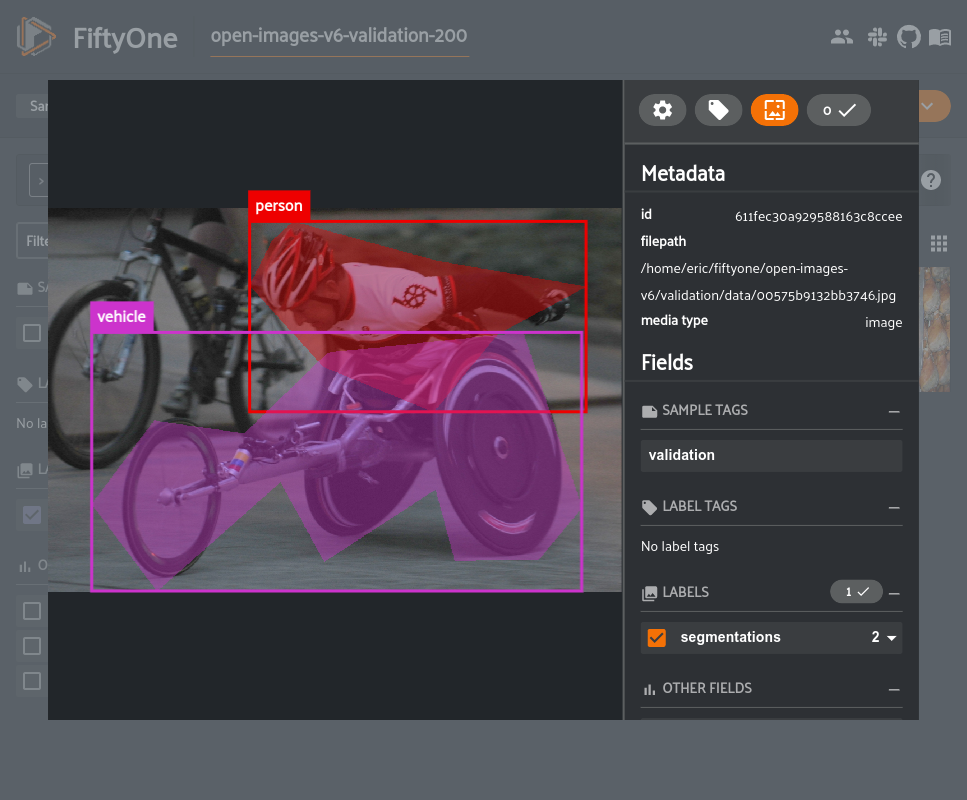

In [3]:
unique_5_view.load_annotations("segs_run", cleanup=True)

session.view = unique_5_view

In [14]:
session.freeze() # screen shot the App for this example

If you want to upload the dataset to a team of annotators, you can provide the CVAT usernames of the annotators and reviewers that will be assigned round-robin style. The `segment_size` parameter is used to define the maximum number of images in each job in your CVAT task.

In [24]:
anno_key = "full_annot"
unique_view.annotate(
    anno_key,
    label_field="ground_truth_cls",
    label_type="classifications",
    classes=["person", "vehicle", "animal"],
    segment_size=25,
    job_reviewers=["user1", "user2"],
    job_assignees=["user3", "user4"],
    task_assignee="user5",
)

Uploading samples to CVAT...
Upload complete


![cvat-assignee](images/cvat_assignees.png)

For larger datasets, the annotation process may take some time. The `anno_key` that we provided stores the relevant information about this annotation run on the dataset itself. When the annotations are ready to be imported back into FiftyOne, we can easily do so.

In [ ]:
dataset.name = "example_dataset"

In practice, annotation tasks can take awhile. But don't worry, you can always load your annotations back onto your dataset in the future in a new Python session:

In [ ]:
import fiftyone as fo

dataset = fo.load_dataset("example_dataset")

anno_key = "full_annot"
dataset.load_annotations(anno_key)

view = dataset.load_annotation_view(anno_key)
session = fo.launch_app(view=view)

### Additional annotation parameters

Creating new labels to exactly match your schema can require a lot of specifics in terms of the classes, attributes, and types that are used. This section outlines how different parameters can be used to specify an annotation run.

#### Single label fields

If only one new label field is being created, then the `label_field`, `label_type`, `classes`, `attributes` and `mask_targets` arguments to [annotate()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.annotate) can be used to specify how to construct the label schema for CVAT.

* `label_field`: the string name of the field to create
* `label_type`: the type of labels that will be created. The supported values are ["classification", "classifications", "detections", "instances", "segmentations", "keypoints", "polylines", "polygons", "scalar"]
* `classes`: a list of class strings available to label
* `attributes`: an optional list or dictionary containing specifications for attributes to annotate on every label

#### Label types

There are a few things to note about label types:

* "classification" creates a single `Classification` label from the first CVAT tag on every sample while "classifications" creates a `Classifications` label storing all CVAT tags on each sample
* "instance" segmentations are downloaded alongside "detections" since they are stored on the `mask` field in the FiftyOne `Detection` label type. Both bounding boxes and segmentation masks can be uploaded from existing `Detections` fields if the label type is left blank
* "scalar" does not accept attributes and optionally takes classes

Expanding on the point about scalar fields, this integrations allows for the creation and editing of integer, float, boolean, and string scalar fields on samples. In CVAT, they are annotated using the `tag` tool. Since scalar fields are not labels, no `attributes` are supported. If a list of `classes` is given, then the `tag` tool in CVAT lets you select from a dropdown of the given classes. If `classes` is not given, then the `tag` tool will require you to type in the scalar value as an attribute in CVAT.

![cvat-tag](images/cvat_tag.png)

#### Attributes

Non-scalar label types support per-label attributes that can be modified and created with CVAT. For existing label fields, these attributes will be parsed automatically if possible to determine the type of attribute annotation format to create. 

For new attributes, they can be specified either as a list of strings of attribute names in which case each attribute is annotated with a text box input in CVAT. Alternatively, a dictionary can be passed in with more concrete specifications of the type of formatting to use for the attributes.

The attribute annotation formats available for CVAT are:

* `text`: a free-form text box. In this case, default is optional and values is unused
* `select`: a selection dropdown. In this case, values is required and default is optional
* `radio`: a radio button list UI. In this case, values is required and default is optional
* `checkbox`: a boolean checkbox UI. In this case, default is optional and values is unused
* `occluded`: CVAT’s builtin occlusion toggle icon. This widget type can only be specified for at most one attribute, which must be a boolean

When you are annotating existing label fields, the `attributes` parameter can take additional values:

* `True` (*default*): export all custom attributes observed on the existing labels, using their observed values to determine the appropriate UI type and possible values, if applicable
* `False`: do not include any custom attributes in the export
* a list of custom attributes to include in the export
* a full dictionary syntax described above

Note that only scalar-valued label attributes are supported. Other attribute types like lists, dictionaries, and arrays will be omitted.

For example, the following will create `attr1` with text-box input and `attr2` with drop-down selection of the given values:

In [24]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")

attributes = {
    "attr1": {
        "type": "text",
    },
    "attr2": {
        "type": "select",
        "values": ["val1", "val2"],
        "default": "val1",
    }
}

random_view = dataset.take(1, seed=51)

anno_key = "random_attrs"
random_view.annotate(
    anno_key,
    label_field="ground_truth",
    attributes=attributes,
    launch_editor=True,
)

Uploading samples to CVAT...
Computing image metadata...
 100% |█████████████████████| 1/1 [141.7ms elapsed, 0s remaining, 7.1 samples/s] 
Samples uploaded successfully
Launching editor for label field 'ground_truth' of type detections at https://app.cvat.ai/tasks/349/jobs/393


In CVAT, `attr1` and `attr2` are now available for annotation on every new and existing label.

![cvat-attrs](images/cvat_attributes.png)

These annotations can now be loaded back into FiftyOne with [load_annotations()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.load_annotations). 


In [26]:
random_view.load_annotations("random_attrs")


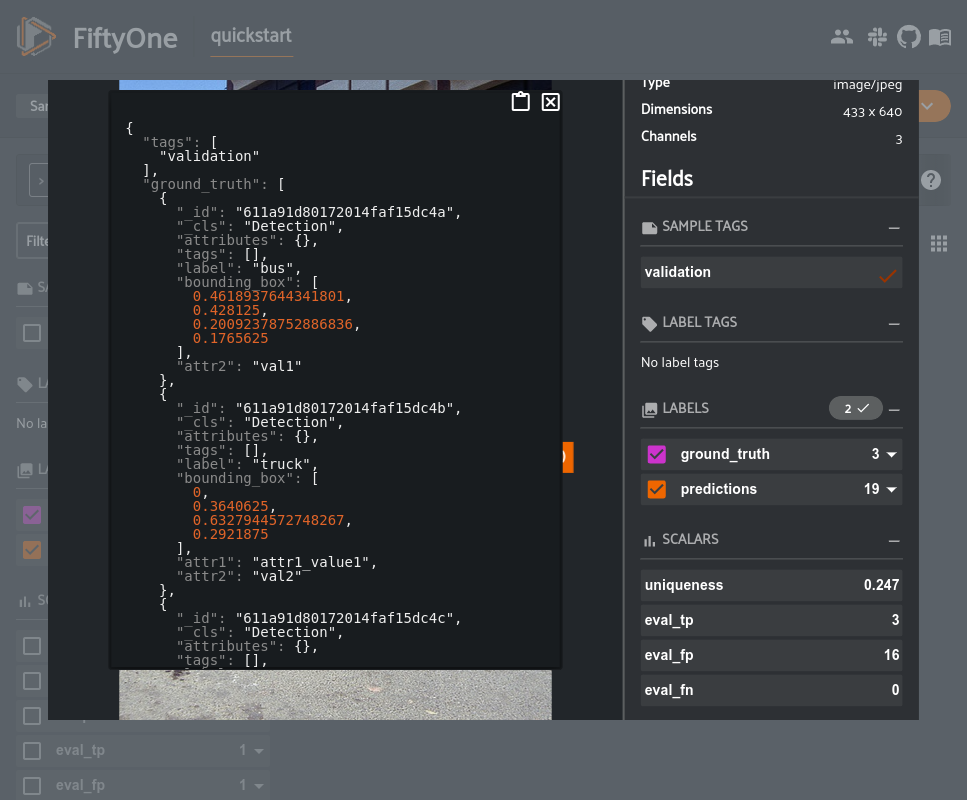

In [27]:
session.view = random_view

In [28]:
session.freeze()

**Note:** When uploading existing labels to CVAT, the id of the labels in FiftyOne are stored in a `label_id` attribute of the CVAT shapes. `label_id` is the single-source of provenance for a label. If this attribute is modified or deleted in CVAT, then FiftyOne will not be able to merge the annotation with its existing Label instance when the annotations are loaded back into FiftyOne. Instead, the existing label will be deleted and a new Label will be created. This can result in data loss if you sent only a subset of the label’s attributes to CVAT.

#### Label schema

In order to annotate multiple label fields at once, or just to specify the field name, label type, classes and attributes in one structure, the `label_schema` argument to [annotate()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.annotate) can be used. This argument accepts a dictionary keyed by label field names that contain a dictionary setting up the type, classes and attributes as follows:

```python
label_schema = {
    "new_field": {
        "type": "detections",
        "classes": ["class_1", "class_2"],
        "attributes": {
            "attr1": {
                "type": "radio",
                "values": ["val1", "val2"],
                "default": "val1",
            }
        }
    },
    "existing_field": {},
}
```

For existing fields, the dictionary entry can be left blank and the relevant information will be parsed. For new fields, the type and classes are required (except for "scalar" type fields) and attributes are optional just like before.

In [39]:
label_schema = {
    "ground_truth": {},
    "gt_segmentations": {
        "type": "instances",
        "classes": ["person", "vehicle", "food"],
        "attributes": {
            "iscrowd": {
                "type": "radio",
                "values": [True, False],
                "default": False,
            }
        }
    }
}

random_view = dataset.take(1, seed=52)

anno_key = "random_segs"
random_view.annotate(anno_key, label_schema=label_schema, launch_editor=True)

Uploading samples to CVAT...
Samples uploaded successfully
Launching editor for label field 'ground_truth' of type instances at https://app.cvat.ai/tasks/354/jobs/398


![cvat-segmentation](images/cvat_segmentation_2.png)

In [40]:
random_view.load_annotations("random_segs")


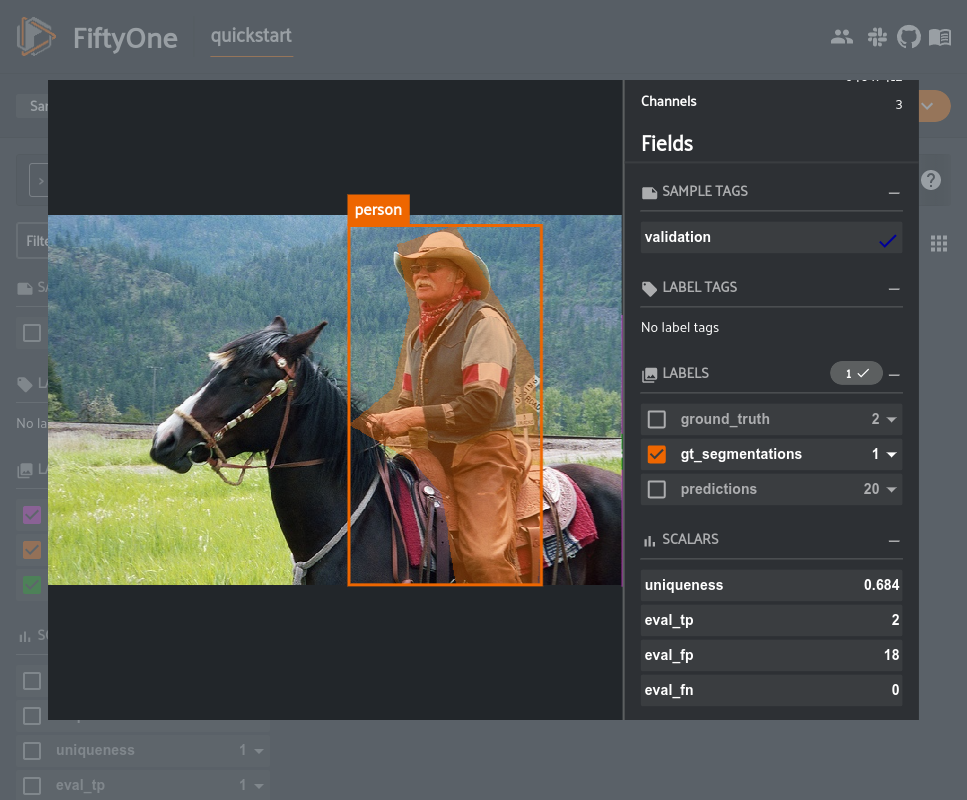

In [41]:
session.view = random_view

In [42]:
session.freeze()

**Note**: CVAT annotation schemas do not have a notion of label fields. Therefore, if you define an annotation schema that involves the same class label in multiple fields, the name of the label field will be appended to the class in CVAT in order to distinguish the class labels.

## Dataset improvement

In many projects, a dataset already exists and is being used to train models. In such cases, the best use of time is likely to improve the quality of the dataset, which often provides greater performance gains than similar effort into optimizing the model architecture.

FiftyOne provides a powerful API and App workflows to identify the samples/annotations that need to be updated, and the tight integration with CVAT allows you to take the necessary actions to improve your dataset's quality.

To demonstrate this workflow, let's load a subset of the [COCO object detection dataset](https://voxel51.com/docs/fiftyone/integrations/coco.html) from the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/index.html). 

In [54]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    max_samples=200,
)

Found annotations at '/home/voxel51/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 200/200 [1.4s elapsed, 0s remaining, 147.7 samples/s]         
Dataset 'coco-2017-validation-200' created


**If your machine has a GPU**, then you can run the following code to generate predictions on the dataset with an object detection model from the [FiftyOne Model Zoo](https://voxel51.com/docs/fiftyone/user_guide/model_zoo/index.html). Note that you can also easily [load your own model predictions](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html#custom-formats) onto your FiftyOne dataset.

In [48]:
model = foz.load_zoo_model("faster-rcnn-resnet50-coco-tf")
dataset.apply_model(model, "predictions")

 100% |█████████████████| 250/250 [3.6m elapsed, 0s remaining, 1.2 samples/s]      


**For CPU only machines**, let's save time and just load the `quickstart` dataset from the dataset zoo, which contains a small subset of COCO with precomputed predictions.

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("quickstart")

Dataset already downloaded
Loading 'quickstart'
 100% |█████████████████| 200/200 [4.3s elapsed, 0s remaining, 38.8 samples/s]      
Dataset 'quickstart' created


Let's visualize these model predictions.


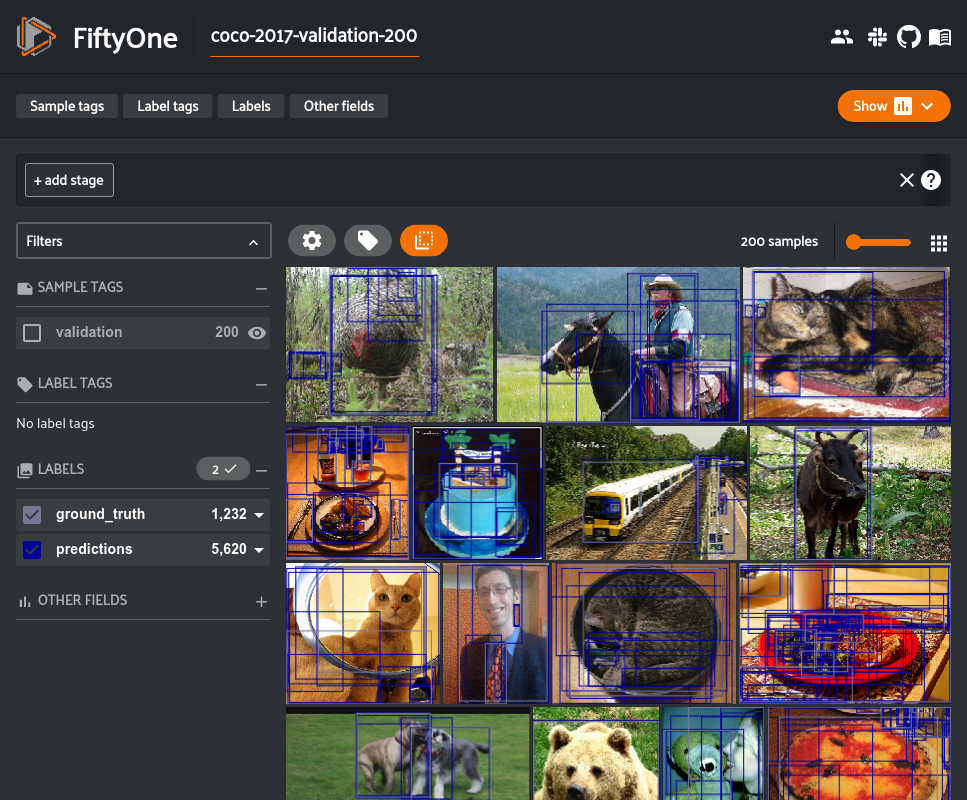

In [60]:
session = fo.launch_app(dataset)

In [31]:
session.freeze() # screen shot the App for this example

In order to find specific cases of how this model performed, we can [evaluate the object detections](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html). When running evaluation, we can provide an `eval_key`, which will cause per-label TP/FP/FN evaluation results to be stored on our samples for future use.

In [5]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)
print(results.mAP())

Evaluating detections...
 100% |█████████████████| 200/200 [6.5s elapsed, 0s remaining, 22.3 samples/s]       
Performing IoU sweep...
 100% |█████████████████| 200/200 [12.5s elapsed, 0s remaining, 15.3 samples/s]      
0.3957238101325776


Using the query language of FiftyOne, we can construct [different views into the dataset](https://voxel51.com/docs/fiftyone/user_guide/using_views.html). Specifically, let's find the samples where the model was confident in its prediction but the prediction was labeled incorrect (false positive). This indicates that the model may have been correct but the ground truth annotation was incorrect.


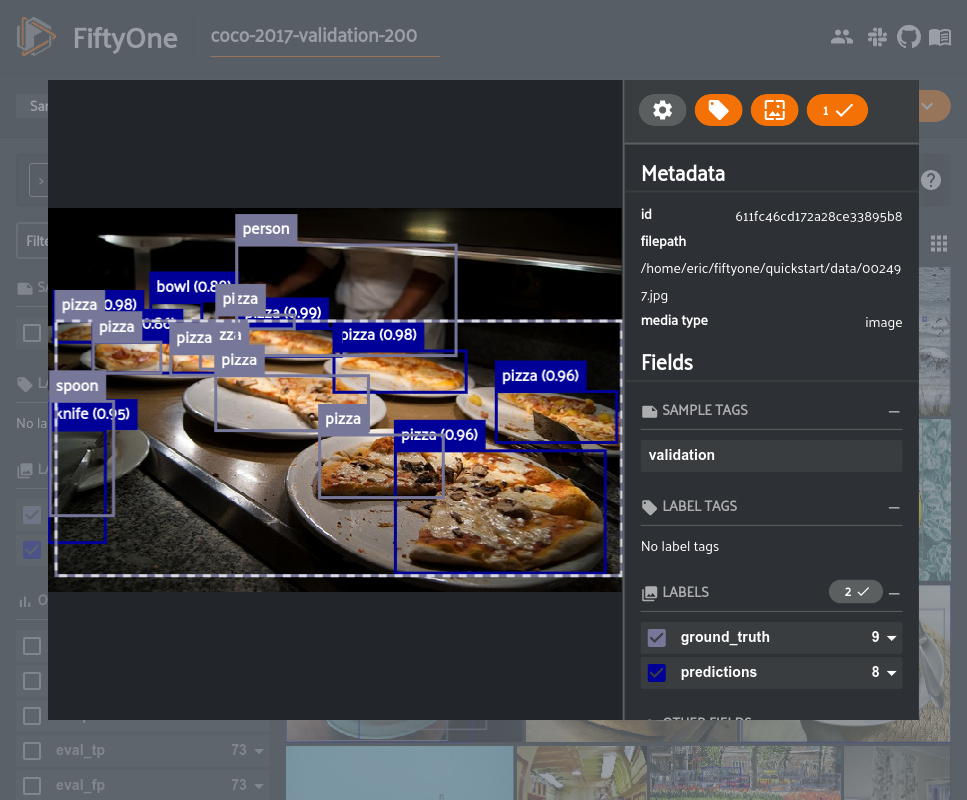

In [61]:
from fiftyone import ViewField as F

view = dataset.filter_labels(
    "predictions",
    (F("confidence") > 0.85) & (F("eval") == "fp")
).sort_by(
    F("predictions.detections").length(),
    reverse=True,
)

session.view = view

In [63]:
session.freeze() # screen shot the App for this example

Browsing through some of these results, we can see a pattern emerge. The COCO dataset annotations have an `iscrowd` attribute that indicates if a bounding box contains a crowd of multiple objects or just a single instance of the object. In many of the situations where the model was incorrect, the `iscrowd` attribute is incorrectly annotated or missing entirely.

We can tag some of these samples for annotation by clicking selecting the relevant samples and clicking the tag button.


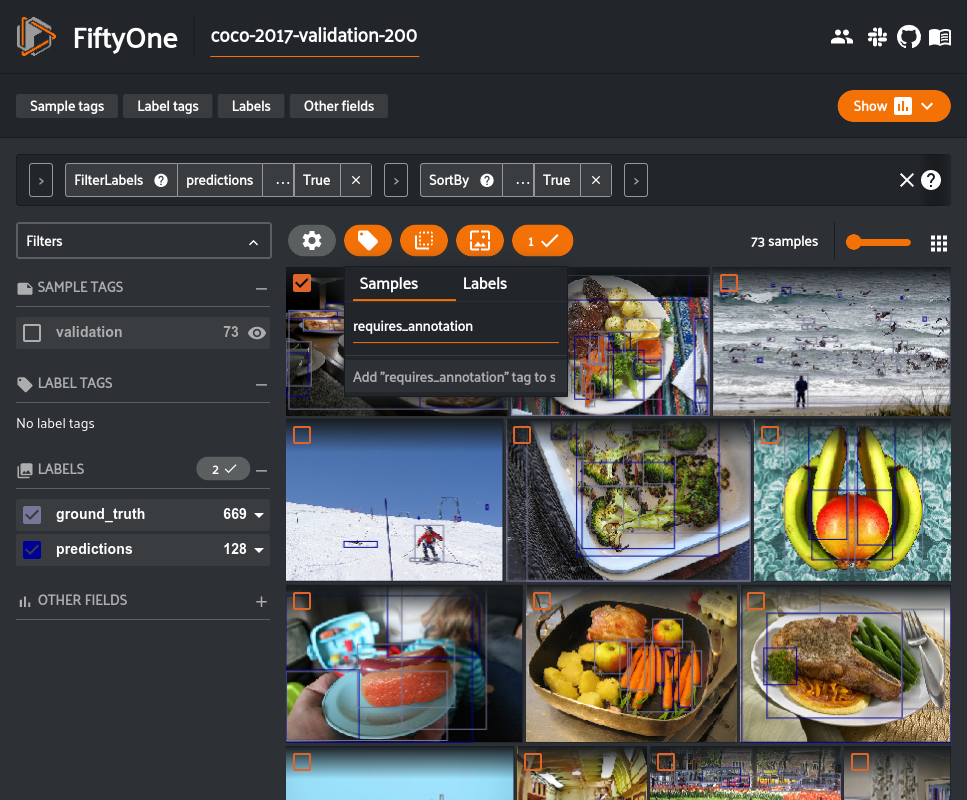

In [64]:
session.show()

In [65]:
session.freeze() # screen shot the App for this example

In [2]:
tagged_view = dataset.match_tags("requires_annotation")

We can now use the `annotate()` method to upload these samples and labels to CVAT for re-annotation.

The following code creates a new task in your account in CVAT containing only the samples with the `requires_annotation` tag.

In [4]:
anno_key = "tagged_anno"
tagged_view.annotate(anno_key, label_field="ground_truth", launch_editor=True)

Uploading samples to CVAT...
Upload complete
Launching editor at 'https://app.cvat.ai/tasks/383/jobs/434'...


In CVAT, click on the box whose `iscrowd` attribute we want to modify. On the attributes sidebar, enter a value of `1` for the attribute:

![cvat-mistake](images/cvat_mistakes.png)

After updating the relevant annotations in all of the samples, make sure to hit the save button in CVAT. Now that the re-annotation is complete, let's load the updated labels back into FiftyOne and clean up the tasks that were created in CVAT.

Download complete
Merging labels for 'ground_truth'...
 100% |█████████████████████| 1/1 [11.1ms elapsed, 0s remaining, 89.9 samples/s] 
 100% |█████████████████████| 1/1 [352.8ms elapsed, 0s remaining, 2.8 samples/s] 



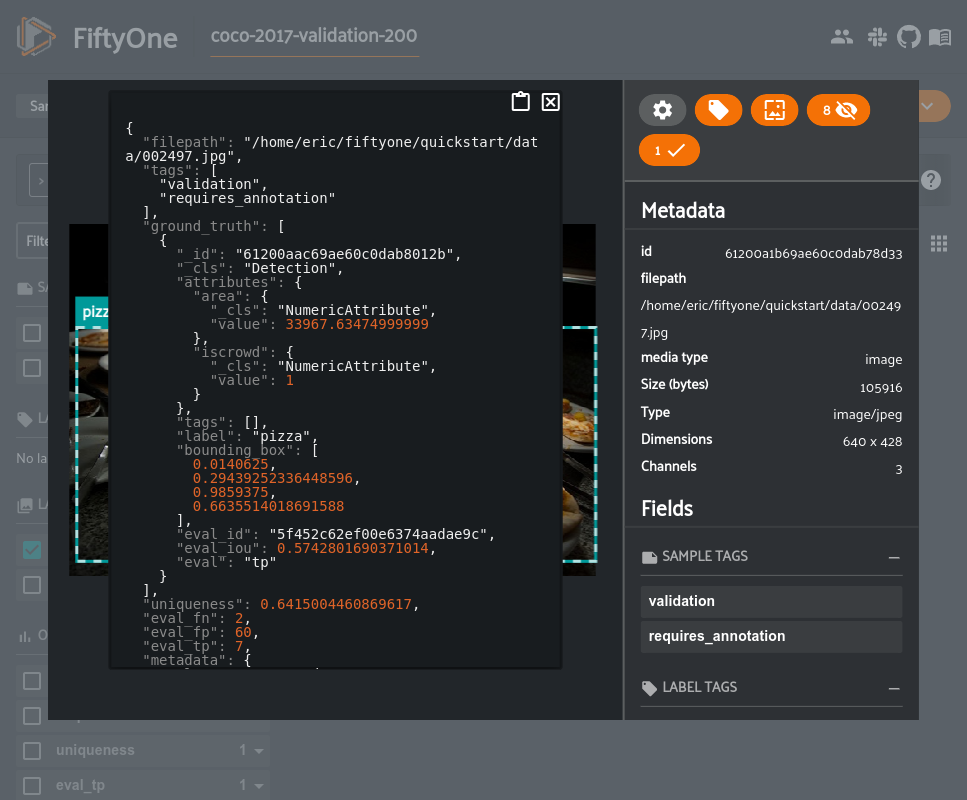

In [10]:
tagged_view.load_annotations("tagged_anno", cleanup=True)
session.view = tagged_view

In [11]:
session.freeze() # screen shot the App for this example

As we can see, the ground truth labels on the dataset have been updated. Let's evaluate the same model again on these updated labels.

In [12]:
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)
print(results.mAP())

Evaluating detections...
 100% |█████████████████| 200/200 [6.1s elapsed, 0s remaining, 28.2 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 200/200 [15.3s elapsed, 0s remaining, 13.2 samples/s]      
0.3984999388520894


The mAP of the model has improved from 39.57% to 39.85% just by updating a single label in one sample!

In practice, the next step is to spend more time exploring the dataset in FiftyOne finding more annotation mistakes and sending them to a team of annotators in CVAT for review and re-annotation. Specific users can be assigned to annotate or review the tasks that are created through this API.

In [ ]:
anno_key = "all_mistakes"
tagged_view.annotate(
    anno_key,
    label_field="ground_truth", 
    segment_size=25,
    task_assignee="user1",
    job_assignees=["user2", "user3"],
    job_reviewers="user4",
)

This workflow has shown how to improve the validation split of a dataset and the subsequent performance of a model on that split. However, we never actually retrained the model at this point!

In practice, a complete workflow might include performing K-fold cross-validation on the dataset. This is where the complete dataset is split into K equal parts where each is treated as the validation split and the model is retrained K times on each combination of the remaining splits. Following the above steps on each of these K validation splits will then result in the entire dataset having been iterated over and improved. Finally, the model should then be retrained on the entirety of this newly updated dataset.

## Annotating videos in CVAT

Videos are handled slightly differently by CVAT. Each task is only able to contain a single video, so if multiple video samples are uploaded at once via a call to `annotate()`, separate tasks will be created for each video.

CVAT primarily allows for per-frame annotations of objects and classifications, so you should prepend `"frames."` to field names to indicate that you are working with frame-level, not sample-level, fields.


All CVAT label types except `tags` provide an option to annotate **tracks** in videos, which captures the identity of a single object as it moves through the video. When you import video tracks into FiftyOne, the `index` attribute of each label will contain the integer number of its track, and any labels that are keyframes will have their `keyframe=True` attribute set.

Let's upload and modify some labels from the `quickstart-video` dataset. The workflow in FiftyOne looks identical to the image-based workflow. The only difference is needing to navigate to each video task separately inside of CVAT.

In [43]:
import fiftyone as fo
import fiftyone.zoo as foz

In [44]:
dataset = foz.load_zoo_dataset("quickstart-video")

Dataset already downloaded
Loading 'quickstart-video'
 100% |███████████████████| 10/10 [5.0s elapsed, 0s remaining, 1.9 samples/s]      
Dataset 'quickstart-video' created


In [45]:
random_view = dataset.take(2, seed=51)

In [50]:
anno_key = "vid_anno"
random_view.annotate(anno_key, label_field="frames.detections", launch_editor=True)

Uploading samples to CVAT...
Computing video metadata...
 100% |█████████████████████| 1/1 [296.8ms elapsed, 0s remaining, 3.4 samples/s] 
Computing video metadata...
 100% |█████████████████████| 1/1 [141.0ms elapsed, 0s remaining, 7.1 samples/s] 
Samples uploaded successfully
Launching editor for label field 'frames.detections' of type detections at https://app.cvat.ai/tasks/356/jobs/400


In CVAT, you can press the play button to watch the video and annotations. 

In the attributes, the tracks that are shown provide some additional options over standard labels. For example, the first square icon with a line coming out of it indicates that the object is "outside" of the frame and should not be loaded into FiftyOne for that frame.

![cvat-video](images/cvat_video.png)

Let's save our annotation work and then load the labels back into FiftyOne.

In [ ]:
random_view.load_annotations("vid_anno", cleanup=True)


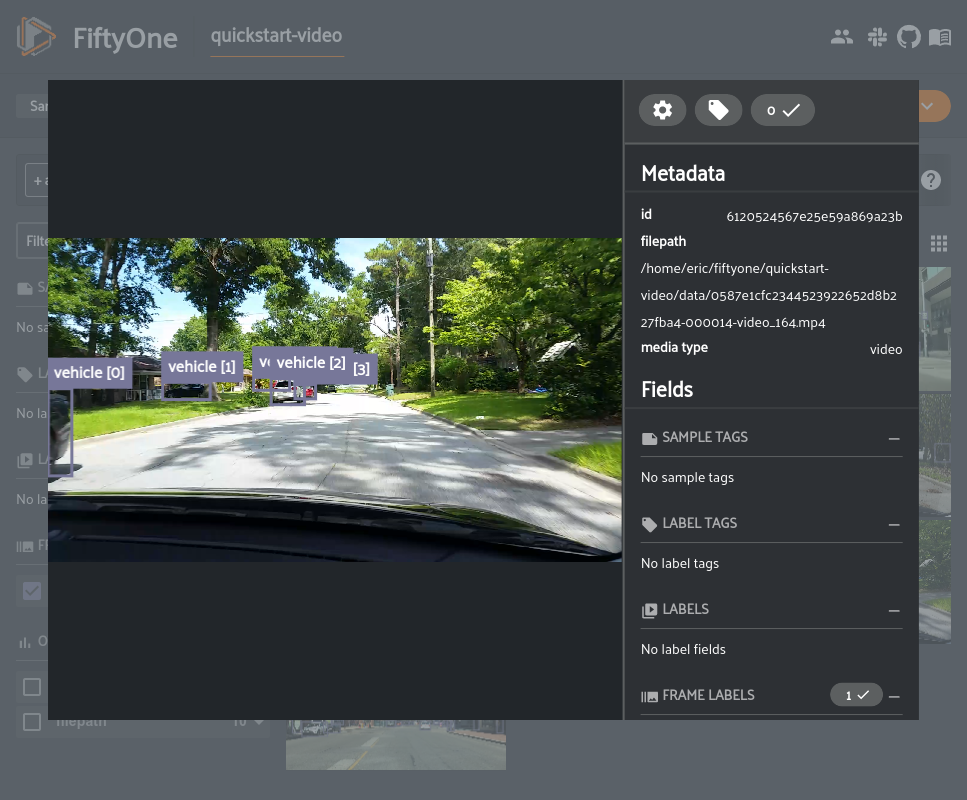

In [5]:
session.view = random_view

In [6]:
session.freeze()

## Summary

Building high-quality datasets is the best way to produce high-performing models, and FiftyOne and CVAT are two open-source tools that you can use to curate and annotate datasets from scratch, as well as explore and re-annotate existing datasets to improve them.

Thanks to the tight integration between FiftyOne and CVAT, the power of one of the most popular open-source annotation tools is just one command away when working with your datasets in FiftyOne.